# Ptychography using gradient descent
### Chengyu Wang, Duke University
### David J. Brady, University of Arizona
### Timothy J. Schulz, Michigan Technological University

This script implements the 2D Fourier ptychography and a phase retrieval algorithm using gradient descent as described in "Photon-limited bounds for phase retrieval."

In [1]:
import tensorflow as tf
import numpy as np
from numpy import matlib
import random
tf.compat.v1.disable_eager_execution()

## Error metrics

If $\underline{F}$ is an $N$-element optical field, and an estimate of this field is $\widehat{\underline{F}}$.
One way to address this is to optimize the MSE over a global phase:
\begin{equation} 
MSE = \underset{\psi}{argmin} \frac{1}{N} \left\| e^{j \psi} \underline{F} - \widehat{\underline{F}} \right\|^2. 
\end{equation}

In [2]:
def minAngMSE(xt,xest):
    mse=(np.abs(np.vdot(xt,xt))+np.abs(np.vdot(xest,xest))-2*np.abs(np.vdot(xt,xest)));
    return mse/xt.shape[0]

## Forward model
For the forward model, $N_x$ is the number of pixels in each dimension of the random gaussian signal, $L_x$ is the size of the subaperture/selected window, and $M_x$ is the size of the each sampld frame. The subaperture moves circularly with step size $\Delta$. The total number of frames is $(\frac{N_x}{\Delta})^2$. We consider $N_x$ and $\Delta$ to be powers of 2.

A phase shift can be added to the window using the argument *is_mask*.

In [3]:
## Dimensions
N = 256
L = 64
pad_size = 32
M = L + pad_size*2
pitch = 16 # Delta
total_frame = int(N/pitch)**2

is_mask = False ## add a phase shift
is_noisy = True  ## add Poisson noise

## Phase mask
Define the phase mask. 3 different examples are shown here.

In [4]:
## random phase mask
mask = np.exp(1j * np.random.random([L,L]) * 2 * np.pi)

# ## periodic phase mask
# K = np.pi/L
# mesh = np.arange(L)
# xlocations,ylocations = np.meshgrid(mesh,mesh);
# mask = np.exp(1j * np.cos(K*xlocations) * np.cos(K*ylocations)  * 2*np.pi)

# ## MURA mask
# def qres(p):
#     qr = np.zeros([p-1])
#     for i in range(p-1):
#         qr[np.mod((i+1)**2,p)-1]=1
#     return qr

# def gen_mura(p):
#     ## p is a prime number
#     mask = np.zeros([p,p])
#     mask[1:,:] = 1
#     qr = qres(p)
#     for i in range(1,p):
#         for j in range(1,p):
#             if qr[i-1] == 1 and qr[j-1] == 1:
#                 mask[i,j] = 1
#             elif qr[i-1] == 0 and qr[j-1] == 0:
#                 mask[i,j] = 1
#             else:
#                 mask[i,j] = 0
#     return mask
# mask = gen_mura(L)*2-1 + 0 * 1j

In [5]:
## selected windows
## xlocations/ylocations save the cordinates of the top left pixels of subaperture/selected windows
mesh = np.arange(0,N,pitch)
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()

## Energy constraint
## Count how many times each pixel (in Fourier domain) is measured
## The energy will be eqaully divided to all measurements
counts = np.zeros([2*N,2*N])
for i in range(total_frame):
     counts[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] += 1
counts = counts[0:N,0:N] + counts[0:N,N:2*N] + counts[N:2*N,0:N] + counts[N:2*N,N:2*N]

## Define the tensorflow graph to compute gradient

In [6]:
## define the tensorflow model
X_FT_EST = tf.compat.v1.placeholder(tf.complex128, shape=(None,L,L))
paddings = tf.constant([[0,0],[pad_size, pad_size], [pad_size, pad_size]])
MEASUREMENT = tf.compat.v1.placeholder(tf.float64, shape=(None,M,M))
if is_mask:
    MASK = tf.constant(mask)
    X_FT_EST_PAD = tf.pad(tf.multiply(X_FT_EST,MASK),paddings)
else:
    X_FT_EST_PAD = tf.pad(X_FT_EST,paddings)
FORWARD = tf.abs(tf.signal.ifft2d(tf.signal.ifftshift(X_FT_EST_PAD,[1,2]))) * M
loss = tf.reshape(tf.cast(tf.math.reduce_sum(tf.math.square(abs(MEASUREMENT)-abs(FORWARD))),tf.complex128),[1,1])
# loss = tf.reshape(tf.cast(tf.compat.v1.losses.mean_squared_error(abs(MEASUREMENT),abs(FORWARD)),tf.complex128),[1,1])
weight = [[1 + 1j*0]]
gradient = tf.gradients(loss, X_FT_EST, grad_ys = weight)

## session
sess = tf.compat.v1.Session()

## Simulation

In phase retirevel, we initialize the gradient descent with a simple projection method. The projection method itself is sensitive to noise, resulting in poor MSE, but it approximates the groundtruth faster than gradient descent method. The phase retrieval implemented in this script has two stages:

- First a projection method approximates the grountruth
- Second the gradient descent algorithm improves the accuracy.

FYI: Because of the circular connections, the if ... elif ... elif ... else part is used to consider different locations of the winsow.

In [7]:
def run_simulation(XT,num_projection_loop = 50, num_gd_iteration = 50,lr = 0.5,return_error = False,verbose = True):
    
    ## XT: signal
    ## num_projection_loop: number of loops for GS projection
    ## num_gd_iteration: number of iterations for gradient descent
    ## lr: learning rate for the gradient descent
    ## return_error: return the reconstruction error
    ## verbose: print the system configurations and the reconstruction error
    
    num_trial = XT.shape[0]
    MSE = np.zeros([num_trial])
    for ct in range(num_trial):
        
        ## signal
        xt = XT[ct,:,:]
        objectFT = np.fft.fftshift(np.fft.fft2(xt))/N/np.sqrt(counts)
        objectFT = matlib.repmat(objectFT, 2, 2)

        ## measurement
        imSeqLowRes = np.zeros([total_frame, M, M]);
        for i in range(total_frame):
            imSeqLowFT = objectFT[xlocations[i]:xlocations[i] + L,ylocations[i]:ylocations[i] + L]
            if is_mask:
                imSeqLowFT = np.pad(imSeqLowFT * mask,pad_size)
            else:
                imSeqLowFT = np.pad(imSeqLowFT,pad_size)
            imSeqLowRes[i,:,:] = np.abs(np.fft.ifft2(np.fft.ifftshift(imSeqLowFT))) * M
        if is_noisy:
            imSeqLowRes = np.sqrt(np.random.poisson(np.power(np.abs(imSeqLowRes),2)))

        ## Projection
        imageRecover = np.random.randn(N,N);
        imageRecoverFT = np.fft.fftshift(np.fft.fft2(imageRecover))
        seq = list(range(total_frame))
        for loop in range(num_projection_loop):
            random.shuffle(seq)
            for i in seq:
                if not xlocations[i] > N - L and not ylocations[i] > N-L:
                    if is_mask:
                        imLowRes = np.fft.ifft2(np.fft.ifftshift(np.pad(imageRecoverFT[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] * mask,pad_size)))
                    else:
                        imLowRes = np.fft.ifft2(np.fft.ifftshift(np.pad(imageRecoverFT[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L],pad_size)))

                    imLowRes = imSeqLowRes[i,:,:] * np.exp(1j * np.angle(imLowRes))
                    inverse = np.fft.fftshift(np.fft.fft2(imLowRes)) / M
                    if is_mask:
                        imageRecoverFT[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] = inverse[pad_size:pad_size+L,pad_size:pad_size+L]/mask
                    else:
                        imageRecoverFT[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] = inverse[pad_size:pad_size+L,pad_size:pad_size+L]
                else:
                    imageRecoverFTRep = matlib.repmat(imageRecoverFT, 2, 2)
                    if is_mask:
                        imLowRes = np.fft.ifft2(np.fft.ifftshift(np.pad(imageRecoverFTRep[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] * mask,pad_size)))
                    else:
                        imLowRes = np.fft.ifft2(np.fft.ifftshift(np.pad(imageRecoverFTRep[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L],pad_size)))
                    imLowRes = imSeqLowRes[i,:,:] * np.exp(1j * np.angle(imLowRes))
                    inverse = np.fft.fftshift(np.fft.fft2(imLowRes)) / M
                    if is_mask:
                        inverse = inverse[pad_size:pad_size+L,pad_size:pad_size+L]/mask
                    else:
                        inverse = inverse[pad_size:pad_size+L,pad_size:pad_size+L]
                    if xlocations[i] > N - L and not ylocations[i] > N-L:
                        imageRecoverFT[xlocations[i]:N,ylocations[i]:ylocations[i]+L] = inverse[0:N-xlocations[i],:]
                        imageRecoverFT[0:L+xlocations[i]-N,ylocations[i]:ylocations[i]+L] = inverse[N-xlocations[i]:,:]
                    elif not xlocations[i] > N - L and ylocations[i] > N-L:
                        imageRecoverFT[xlocations[i]:xlocations[i]+L,ylocations[i]:N] = inverse[:,0:N-ylocations[i]]
                        imageRecoverFT[xlocations[i]:xlocations[i]+L,0:L+ylocations[i]-N] = inverse[:,N-ylocations[i]:]
                    else:
                        imageRecoverFT[xlocations[i]:N,ylocations[i]:N] = inverse[0:N-xlocations[i],0:N-ylocations[i]]
                        imageRecoverFT[0:L+xlocations[i]-N,0:L+ylocations[i]-N] = inverse[N-xlocations[i]:N,N-ylocations[i]:]
                        imageRecoverFT[xlocations[i]:N,0:L+ylocations[i]-N] = inverse[0:N-xlocations[i],N-ylocations[i]:]
                        imageRecoverFT[0:L+xlocations[i]-N,ylocations[i]:N] = inverse[N-xlocations[i]:,0:N-ylocations[i]]
#             if verbose:
#                 imageRecover=np.fft.ifft2(np.fft.ifftshift(imageRecoverFT*np.sqrt(counts))) * N
#                 print(loop,minAngMSE(xt.flatten(),imageRecover.flatten()),end='\r',flush=True)

        ## Gradient descent
        for iter_ in range(num_gd_iteration):
            imageRecoverFTRep = matlib.repmat(imageRecoverFT, 2, 2)
            batch_tensor = np.zeros([total_frame ,L, L]) * 1j
            for i in range(total_frame):
                batch_tensor[i,:,:] = imageRecoverFTRep[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L]
            gradient_sum = np.zeros([N,N]) * 1j
            gradient_tensor = sess.run(gradient,feed_dict={X_FT_EST:batch_tensor,MEASUREMENT:imSeqLowRes})[0]
            for i in range(total_frame):
                if not xlocations[i] > N - L and not ylocations[i] > N-L:
                    gradient_sum[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] += gradient_tensor[i,:,:]
                elif xlocations[i] > N - L and not ylocations[i] > N-L:
                    gradient_sum[xlocations[i]:N,ylocations[i]:ylocations[i]+L] += gradient_tensor[i,0:N-xlocations[i],:]
                    gradient_sum[0:L+xlocations[i]-N,ylocations[i]:ylocations[i]+L] += gradient_tensor[i,N-xlocations[i]:,:]
                elif not xlocations[i] > N - L and ylocations[i] > N-L:
                    gradient_sum[xlocations[i]:xlocations[i]+L,ylocations[i]:N] += gradient_tensor[i,:,0:N-ylocations[i]]
                    gradient_sum[xlocations[i]:xlocations[i]+L,0:L+ylocations[i]-N] += gradient_tensor[i,:,N-ylocations[i]:]
                else:
                    gradient_sum[xlocations[i]:N,ylocations[i]:N] += gradient_tensor[i,0:N-xlocations[i],0:N-ylocations[i]]
                    gradient_sum[0:L+xlocations[i]-N,0:L+ylocations[i]-N] += gradient_tensor[i,N-xlocations[i]:N,N-ylocations[i]:]
                    gradient_sum[xlocations[i]:N,0:L+ylocations[i]-N] += gradient_tensor[i,0:N-xlocations[i],N-ylocations[i]:]
                    gradient_sum[0:L+xlocations[i]-N,ylocations[i]:N] += gradient_tensor[i,N-xlocations[i]:,0:N-ylocations[i]]      
            imageRecoverFT = imageRecoverFT - lr * gradient_sum/counts
#             if verbose:
#                 imageRecover=np.fft.ifft2(np.fft.ifftshift(imageRecoverFT*np.sqrt(counts))) * N
#                 print(iter_,minAngMSE(xt.flatten(),imageRecover.flatten()),end='\r',flush=True)
        imageRecover=np.fft.ifft2(np.fft.ifftshift(imageRecoverFT*np.sqrt(counts))) * N
        MSE[ct] = minAngMSE(xt.flatten(),imageRecover.flatten())
    if verbose:
        print('photons = %d, pitch = %d,L = %d, M = %d, MSE = %f.'%(photons,pitch,L,M,np.mean(MSE)))
    if return_error:
        return np.mean(MSE)

In [8]:
num_trial = 10 # number of signals in simulation
photons = 1e6 # the expected number of photons per element
XT = np.random.randn(num_trial,N,N)+1j*np.random.randn(num_trial,N,N);
XT = np.sqrt(photons)*XT/np.sqrt(2.)
run_simulation(XT,num_projection_loop=100,num_gd_iteration=50)

photons = 1000000, pitch = 16,L = 64, M = 128, MSE = 1.109946.


## MSE vs L

In [9]:
import matplotlib.pyplot as plt

In [10]:
num_trial = 1
photons = 1e6
XT = np.random.randn(num_trial,N,N)+1j*np.random.randn(num_trial,N,N);
XT = np.sqrt(photons)*XT/np.sqrt(2.)

MSE = np.zeros([4])
L_list = [16,32,64,128]
for idx in range(len(L_list)):
    ## dimensions
    L = L_list[idx]
    N = 256
    pad_size = int(L/2)
    M = 2 * L
    pitch = int(L/4)
    total_frame = int(N/pitch)**2

    is_mask = True
    is_noisy = True 
    
    ## random phase mask
    mask = np.exp(1j * np.random.random([L,L]) * 2 * np.pi)
    
    ## selected windows
    mesh = np.arange(0,N,pitch)
    xlocations,ylocations = np.meshgrid(mesh,mesh);
    xlocations = xlocations.astype(int).flatten()
    ylocations = ylocations.astype(int).flatten()

    ## Energy constraint
    counts = np.zeros([2*N,2*N])
    for i in range(total_frame):
         counts[xlocations[i]:xlocations[i]+L,ylocations[i]:ylocations[i]+L] += 1
    counts = counts[0:N,0:N] + counts[0:N,N:2*N] + counts[N:2*N,0:N] + counts[N:2*N,N:2*N]
    
    ## define the tensorflow model
    tf.compat.v1.reset_default_graph()
    X_FT_EST = tf.compat.v1.placeholder(tf.complex128, shape=(None,L,L))
    paddings = tf.constant([[0,0],[pad_size, pad_size], [pad_size, pad_size]])
    MEASUREMENT = tf.compat.v1.placeholder(tf.float64, shape=(None,M,M))
    if is_mask:
        MASK = tf.constant(mask)
        X_FT_EST_PAD = tf.pad(tf.multiply(X_FT_EST,MASK),paddings)
    else:
        X_FT_EST_PAD = tf.pad(X_FT_EST,paddings)
    FORWARD = tf.abs(tf.signal.ifft2d(tf.signal.ifftshift(X_FT_EST_PAD,[1,2]))) * M
    loss = tf.reshape(tf.cast(tf.math.reduce_sum(tf.math.square(abs(MEASUREMENT)-abs(FORWARD))),tf.complex128),[1,1])
    weight = [[1 + 1j*0]]
    gradient = tf.gradients(loss, X_FT_EST, grad_ys = weight)
    sess = tf.compat.v1.Session()
    
    ## simulations
    ## num_projection_loop is set based on experience
    if L == 16:
        MSE[idx] = run_simulation(XT,num_projection_loop = 200,num_gd_iteration = 100,return_error = True)
    else:
        MSE[idx] = run_simulation(XT,num_projection_loop = int(1000/L),num_gd_iteration = 20,return_error = True)

photons = 1000000, pitch = 4,L = 16, M = 32, MSE = 1.036618.
photons = 1000000, pitch = 8,L = 32, M = 64, MSE = 1.030497.
photons = 1000000, pitch = 16,L = 64, M = 128, MSE = 1.023170.
photons = 1000000, pitch = 32,L = 128, M = 256, MSE = 1.021987.


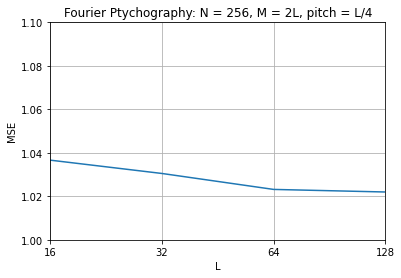

In [13]:
plt.plot(MSE)
plt.xticks([0, 1, 2, 3], ['16', '32', '64','128']) 
plt.grid()
plt.xlim([0,3])
plt.ylim([1.0,1.1])
plt.title('Fourier Ptychography: N = 256, M = 2L, pitch = L/4')
plt.xlabel('L')
plt.ylabel('MSE')
plt.show()